###  ~~MicroGrad~~ Cugrad demo

(Adapted from [the original MicroGrad demo](https://github.com/karpathy/micrograd/blob/master/demo.ipynb) )

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from cugrad.tensor import Tensor
from cugrad.nn import Neuron, Layer, MLP
from cugrad import set_device, DeviceType

# Use CPU for demo
# If you use CUDA with set_device(DeviceType.CUDA), you will need to adapt the code to send the tensors to GPU with tensor.to_device(DeviceType.CUDA)
set_device(DeviceType.CPU)

In [13]:
np.random.seed(1337)
random.seed(1337)

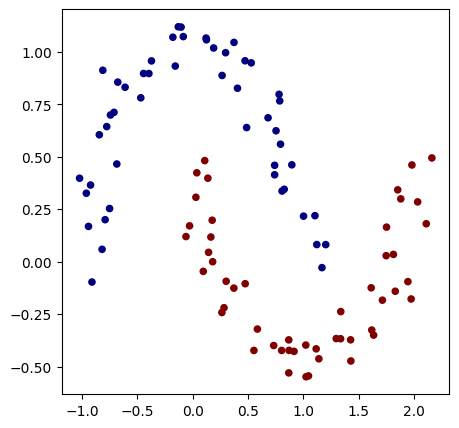

In [14]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [15]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 66


In [16]:
from cugrad import StackOp

# Reduces a list of tensors into a single tensor by summing them all
def tensor_list_sum(tensors):
    stack = StackOp(tensors)
    stack.forward()
    return stack.output.sum()

# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [Tensor(xrow) for xrow in Xb]
    # forward the model to get scores
    scores = list(map(model, inputs))
    # svm "max-margin" loss
    res = [(Tensor([float(yi.tolist())])*scorei).tanh() for yi, scorei in zip(yb, scores)]
        
    losses = [Tensor([1.0]) + Tensor([-1.0]) * (Tensor([float(yi.tolist())])*scorei).tanh() for yi, scorei in zip(yb, scores)]

    sm = tensor_list_sum(losses)
    data_loss = sm * Tensor([1.0 / len(losses)])
    # L2 regularization
    alpha = 1e-4
    reg_loss = tensor_list_sum([Tensor([alpha]) * (p*p).sum() for p in model.parameters()])
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data[0] > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()

In [17]:
# optimization
for k in range(200):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1e-1
    for p in model.parameters():
        # p.data, p.grad is an array so we need elementwise operations
        p.data = list(map(lambda x: x[0] - learning_rate * x[1], zip(p.data, p.grad)))
    
    if k % 20 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss [0.9588966369628906], accuracy 50.0%
step 20 loss [0.28138309717178345], accuracy 90.0%
step 40 loss [0.22918903827667236], accuracy 93.0%
step 60 loss [0.18861761689186096], accuracy 93.0%
step 80 loss [0.14936478435993195], accuracy 96.0%
step 100 loss [0.11677947640419006], accuracy 98.0%
step 120 loss [0.09419756382703781], accuracy 99.0%
step 140 loss [0.0788232609629631], accuracy 100.0%
step 160 loss [0.06789399683475494], accuracy 100.0%
step 180 loss [0.05979381874203682], accuracy 100.0%


(-1.548639298268643, 1.951360701731357)

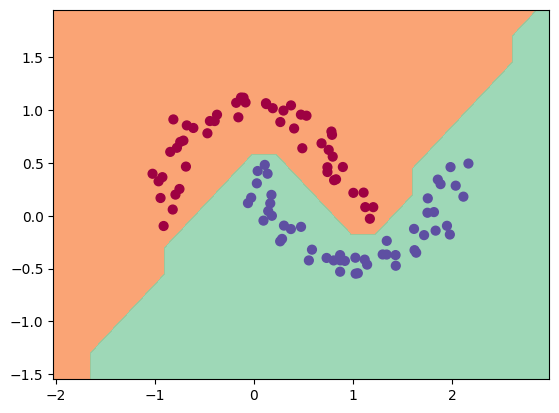

In [18]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [Tensor(xrow) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data[0] > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
